<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Algorithm 10 - Deep Learning Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Part 2: Indonesia Poverty Prediction</h2> 

# Table of Contents
[Introduction](#introduction)  
[Deep Learning with Simple Features](#dl-simple)  
[Deep Learning with Full Features](#all-feats)  
&nbsp;&nbsp;&nbsp;[Undersampling](#undersampling)  
&nbsp;&nbsp;&nbsp;[Oversampling](#oversampling)  
&nbsp;&nbsp;&nbsp;[Tune Parameters and Cross-Validate](#tune-cv)  
[Feature Selection](#feature-selection)  
[Summary](#summary)

# Introduction <a class="anchor" id="introduction"></a>

We will now apply the deep learning classifier to the Indonesia dataset and explore how having an unbalanced dataset impacts the classifier performance. 

As always, we start with loading our standard libraries and the Indonesia data

In [1]:
%matplotlib inline

import os
import sys
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize
from features.process_features import IDN_BASIC_FEATURES

ALGORITHM_NAME = 'dl'
COUNTRY = 'idn'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

# load text of survey questions for reference
with open(QUESTIONS_PATH, 'r') as fp:
    questions = json.load(fp)

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}' \
        .format(*y_train.poor.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_train.head()

Data has 53,132 rows and 453 columns
Percent poor: 9.0% 	Percent non-poor: 91.0%


,geo_district,geo_subdistrict,geo_village,der_hhsize,hld_nbcell,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpast3mo,...,cons_333__Yes,cons_334__Yes,cons_335__Yes,cons_336__Yes,cons_338__Yes,cons_339__Yes,cons_340__Yes,cons_341__Yes,cons_342__Yes,cons_343__Yes
hid,,,,,,,,,,,,,,,,,,,,,
8271030150650101,8271,30,15,5,1,1,2,2,5,1,...,1,0,0,0,0,0,0,0,0,0
7316020200500509,7316,20,13,5,1,4,0,1,2,0,...,1,0,0,0,0,0,0,0,0,0
5108050200860107,5108,50,4,3,0,0,0,3,0,2,...,0,0,0,0,0,0,0,0,1,0
3301190201430210,3301,190,15,2,1,0,1,1,2,2,...,0,0,0,0,0,0,0,0,0,0
6304140250030508,6304,140,4,6,4,1,3,2,5,3,...,0,0,0,0,0,0,0,0,0,0


# Deep Learning with simple features <a class="anchor" id="mlp-simple"></a>

We'll start with the simple set of features stored in `IDN_BASIC_FEATURES` in the `process_features` module.

In [3]:
# Select the basic features we've used previously
selected_columns = IDN_BASIC_FEATURES
print("X shape with selected columns:", X_train[selected_columns].shape)

X shape with selected columns: (53132, 9)


In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(input_dim=None, hidden_layer_sizes=None, keep_prob=1.0, dropout_layers=None):

    if hidden_layer_sizes is None:
        # make simple two layer network
        hidden_layer_sizes = np.ceil(np.sqrt(input_dim))
    
    # create model
    model = Sequential()
    for i,layer_size in enumerate(hidden_layer_sizes):
        if i==0:
            # include input_dim specification
            model.add(Dense(layer_size, input_dim=input_dim, activation='relu'))
        else:
            model.add(Dense(layer_size, activation='relu'))
            if dropout_layers == 'all':
                model.add(Dropout(keep_prob))
    
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.model.summary())
    return model

In [5]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, 
                                      selected_columns=selected_columns)

# Provide input parameters
input_dim = X_train.shape[1]
hidden_layer_sizes = (16,32,64,32,16)

# Fit the model
model = KerasClassifier(build_fn=create_model, 
                        input_dim=input_dim, 
                        hidden_layer_sizes=hidden_layer_sizes, 
                        keep_prob=0.7,
                        dropout_layers='all',
                        epochs=10, 
                        batch_size=10, 
                        verbose=1)

%time model.fit(X_train.as_matrix(), y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1_input (InputLayer)   (None, 9)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
__________

In [6]:
# Get an initial score
%time score = model.score(X_train.as_matrix(), y_train)
print("In-sample score: {:0.2%}".format(score))

53132/53132 [==============================] - 9s 175us/step
CPU times: user 15.1 s, sys: 2.44 s, total: 17.5 s
Wall time: 9.3 s
In-sample score: 90.98%


17711/17711 [==============================] - 2s 117us/step


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


70843/70843 [==============================] - 8s 115us/step


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


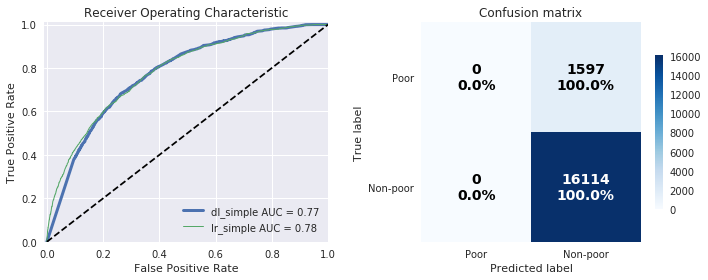

,dl_simple,lr_simple
accuracy,0.90983,0.91158
recall,0,0.0851597
precision,0,0.564315
f1,0,0.147987
cross_entropy,0.277978,0.256817
roc_auc,0.7738,0.781848
cohen_kappa,0,0.127352


Actual poverty rate: 11.38% 
Predicted poverty rate: 0.00% 


In [7]:
# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, 
                                   selected_columns=selected_columns)

# Run the model
y_pred = model.predict(X_test.as_matrix())
y_prob = model.predict_proba(X_test.as_matrix())[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    compare_models=['lr_simple'],
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

# Keras with all features <a class="anchor" id="all-feats"></a>

Now let's apply the deep learning classifier to the dataset with all features. 

In [8]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

input_dim = X_train.shape[1]
hidden_layer_sizes = (700, 1024, 512, 256, 128, 64)
# Fit the model
model = KerasClassifier(build_fn=create_model, 
                        input_dim=input_dim, 
                        hidden_layer_sizes=hidden_layer_sizes,
                        keep_prob=0.7,
                        dropout_layers='all',
                        epochs=10, 
                        batch_size=10, 
                        verbose=1)

%time model.fit(X_train.as_matrix(), y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7_input (InputLayer)   (None, 453)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 700)               317800    
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              717824    
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
__________

In [9]:
# Get an initial score
%time score = model.score(X_train.as_matrix(), y_train)
print("In-sample score: {:0.2%}".format(score))

53132/53132 [==============================] - 19s 362us/step
CPU times: user 1min 45s, sys: 23.1 s, total: 2min 8s
Wall time: 19.3 s
In-sample score: 90.98%


17711/17711 [==============================] - 6s 326us/step


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


70843/70843 [==============================] - 23s 319us/step


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


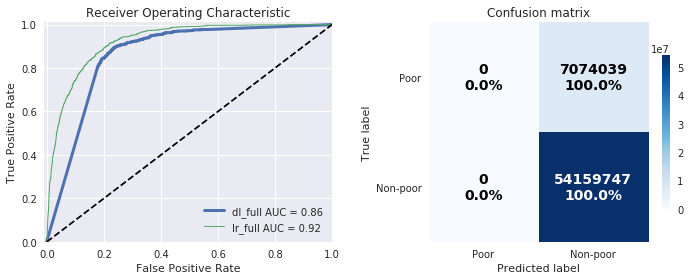

,dl_full,lr_full
accuracy,0.884475,0.910251
recall,0,0.456232
precision,0,0.661838
f1,0,0.540131
cross_entropy,0.38995,0.212947
roc_auc,0.863934,0.923198
cohen_kappa,0,0.483497


Actual poverty rate: 11.38% 
Predicted poverty rate: 0.00% 


In [10]:
# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test.as_matrix())
y_prob = model.predict_proba(X_test.as_matrix())[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_full',
                                    store_model=True,
                                    model_name='full', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

It appears that the deep learning network in this case is highly affected by the unbalanced classes, so it is essentially predicting everything as non-poor. Deep Learning networks typically produce better results when the classes are balanced or weighted, so we will need to apply these techniques with this dataset to get useful results.

## Undersampling <a class="anchor" id="undersampling">
Now we'll apply undersampling and see how the performance is affected.

In [11]:
from imblearn.under_sampling import RandomUnderSampler

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply random undersampling
X_train, y_train = RandomUnderSampler().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after undersampling: ", X_train.shape)

input_dim = X_train.shape[1]
hidden_layer_sizes = (700, 1024, 512, 256, 128, 64)

# Fit the model
model = KerasClassifier(build_fn=create_model, 
                        input_dim=input_dim, 
                        hidden_layer_sizes=hidden_layer_sizes,
                        keep_prob=0.7,
                        dropout_layers='all',
                        epochs=10, 
                        batch_size=10, 
                        verbose=1)

%time model.fit(X_train.as_matrix(), y_train)

X shape after undersampling:  (9584, 453)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14_input (InputLayer)  (None, 453)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 700)               317800    
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              717824    
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None

In [12]:
# Get an initial score
%time score = model.score(X_train.as_matrix(), y_train)
print("In-sample score: {:0.2%}".format(score))

9584/9584 [==============================] - 4s 373us/step
CPU times: user 19.4 s, sys: 3.72 s, total: 23.1 s
Wall time: 3.58 s
In-sample score: 95.72%


17711/17711 [==============================] - 6s 324us/step
CPU times: user 33.7 s, sys: 7.03 s, total: 40.8 s
Wall time: 5.79 s
17711/17711 [==============================] - 6s 326us/step
CPU times: user 33.7 s, sys: 7.69 s, total: 41.4 s
Wall time: 5.81 s
70843/70843 [==============================] - 23s 320us/step


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


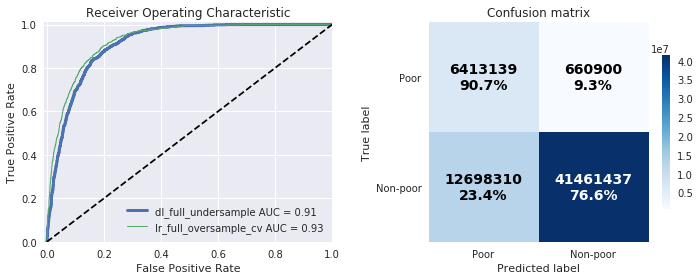

,dl_full_undersample,lr_full_oversample_cv
accuracy,0.781833,0.851611
recall,0.906574,0.838116
precision,0.335565,0.427456
f1,0.489824,0.566159
cross_entropy,0.502852,0.348544
roc_auc,0.911436,0.925356
cohen_kappa,0.384297,0.471316


Actual poverty rate: 11.38% 
Predicted poverty rate: 30.29% 


In [13]:
# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
%time y_pred = model.predict(X_test.as_matrix())
%time y_prob = model.predict_proba(X_test.as_matrix())[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='full_undersample', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

## Oversampling <a class="anchor" id="oversampling">

In [14]:
from imblearn.over_sampling import SMOTE

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply oversampling with SMOTE
X_train, y_train = SMOTE().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after oversampling: ", X_train.shape)

input_dim = X_train.shape[1]
hidden_layer_sizes = (700, 1024, 512, 256, 128, 64)

# Fit the model
model = KerasClassifier(build_fn=create_model, 
                        input_dim=input_dim, 
                        hidden_layer_sizes=hidden_layer_sizes,
                        keep_prob=0.7,
                        dropout_layers='all',
                        epochs=10, 
                        batch_size=10, 
                        verbose=1)

%time model.fit(X_train.as_matrix(), y_train)

X shape after oversampling:  (96680, 453)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21_input (InputLayer)  (None, 453)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 700)               317800    
_________________________________________________________________
dense_22 (Dense)             (None, 1024)              717824    
_________________________________________________________________
dropout_15 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None

In [15]:
# Get an initial score
%time score = model.score(X_train.as_matrix(), y_train)
print("In-sample score: {:0.2%}".format(score))

96680/96680 [==============================] - 36s 371us/step
CPU times: user 3min 9s, sys: 46.1 s, total: 3min 55s
Wall time: 35.9 s
In-sample score: 94.34%


17711/17711 [==============================] - 6s 338us/step
CPU times: user 33.5 s, sys: 7.87 s, total: 41.3 s
Wall time: 6.03 s
17711/17711 [==============================] - 6s 331us/step
CPU times: user 33.4 s, sys: 8.3 s, total: 41.7 s
Wall time: 5.91 s
70843/70843 [==============================] - 23s 327us/step


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


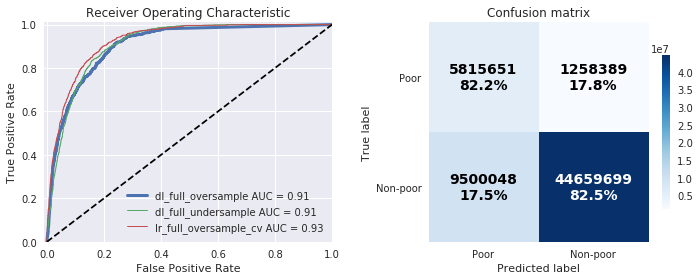

,dl_full_oversample,dl_full_undersample,lr_full_oversample_cv
accuracy,0.824306,0.781833,0.851611
recall,0.822112,0.906574,0.838116
precision,0.379718,0.335565,0.427456
f1,0.519493,0.489824,0.566159
cross_entropy,0.73027,0.502852,0.348544
roc_auc,0.906325,0.911436,0.925356
cohen_kappa,0.420904,0.384297,0.471316


Actual poverty rate: 11.38% 
Predicted poverty rate: 23.01% 


In [16]:
# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
%time y_pred = model.predict(X_test.as_matrix())
%time y_prob = model.predict_proba(X_test.as_matrix())[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['dl_full_undersample', 
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='full_oversample', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

## Tune parameters and cross-validate <a class="anchor" id="tune-cv"></a>


In [17]:
from sklearn.model_selection import GridSearchCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply random undersampling
X_train, y_train = RandomUnderSampler().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after undersampling: ", X_train.shape)

input_dim = X_train.shape[1]
# build the model
estimator = KerasClassifier(build_fn=create_model, 
                            input_dim=input_dim, 
                            dropout_layers='all',
                            epochs=10,
                            verbose=1)
parameters = {'hidden_layer_sizes': [(700, 1024, 512, 256, 128, 64)],
              'keep_prob': [0.5, 0.6, 0.7],
              'batch_size': [10, 64, 128, 256]
             }

model = GridSearchCV(estimator, parameters, verbose=3, cv=3)
%time model.fit(X_train.as_matrix(), y_train)

X shape after undersampling:  (9584, 453)
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] batch_size=10, hidden_layer_sizes=(700, 1024, 512, 256, 128, 64), keep_prob=0.5 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28_input (InputLayer)  (None, 453)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 700)               317800    
_________________________________________________________________
dense_29 (Dense)             (None, 1024)              717824    
_________________________________________________________________
dropout_20 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_21 (Dropout

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35_input (InputLayer)  (None, 453)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 700)               317800    
_________________________________________________________________
dense_36 (Dense)             (None, 1024)              717824    
_________________________________________________________________
dropout_25 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_26 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 256)               131328    
__________

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.4min remaining:    0.0s


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42_input (InputLayer)  (None, 453)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 700)               317800    
_________________________________________________________________
dense_43 (Dense)             (None, 1024)              717824    
_________________________________________________________________
dropout_30 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_31 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 256)               131328    
__________

In [18]:
# Get an initial score
%time score = model.score(X_train.as_matrix(), y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)

9584/9584 [==============================] - 2s 229us/step
CPU times: user 6.81 s, sys: 1.14 s, total: 7.95 s
Wall time: 2.2 s
In-sample score: 95.32%
Best model parameters: {'batch_size': 128, 'hidden_layer_sizes': (700, 1024, 512, 256, 128, 64), 'keep_prob': 0.7}


70843/70843 [==============================] - 4s 63us/step


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


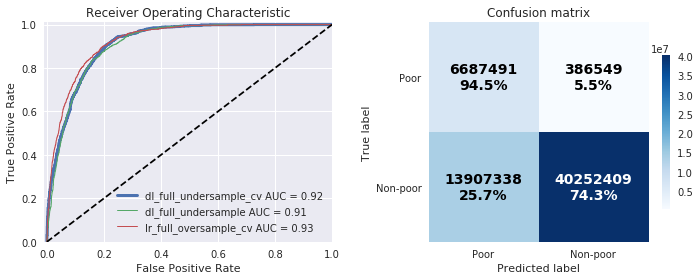

,dl_full_undersample_cv,dl_full_undersample,lr_full_oversample_cv
accuracy,0.766569,0.781833,0.851611
recall,0.945357,0.906574,0.838116
precision,0.324717,0.335565,0.427456
f1,0.483395,0.489824,0.566159
cross_entropy,0.682407,0.502852,0.348544
roc_auc,0.91597,0.911436,0.925356
cohen_kappa,0.382015,0.384297,0.471316


Actual poverty rate: 11.38% 
Predicted poverty rate: 32.77% 


In [19]:
# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test.as_matrix())
y_prob = model.predict_proba(X_test.as_matrix())[:,1]


# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['dl_full_undersample',  
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='full_undersample_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model.best_estimator_,
                                    features=X_test.columns.values)
best_model = model.best_estimator_

Cross validation for this model has only a minor impact on performance. As with Logistic Regression, we tend to get better recall using undersamping, but better overall performance using oversampling. 

# Deep Learning Indonesia Summary <a class="anchor" id="summary"></a>



/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


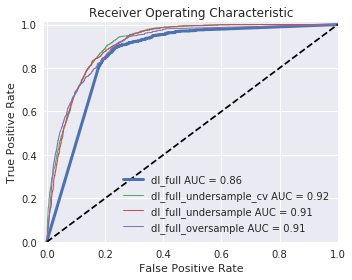

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error
dl_full,0.884475,0,0,0,0.38995,0.863934,0,-0.113791
dl_full_undersample_cv,0.766569,0.945357,0.324717,0.483395,0.682407,0.91597,0.382015,0.213883
dl_full_undersample,0.781833,0.906574,0.335565,0.489824,0.502852,0.911436,0.384297,0.189144
dl_full_oversample,0.824306,0.822112,0.379718,0.519493,0.73027,0.906325,0.420904,0.11632


In [20]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)